Hyperparameters definition and loading of CIFAR100 from pytorch torchvision

In [1]:
from comet_ml import Experiment
import torch
import torchvision
import torchvision.transforms as transforms

train_portion = 0.7

#controllare che len(val) è len(train)

#hyperparameters
batch_size = 250

#pad_totensor_transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]) # does the padding, images 32x32 become 36x36 (symmetric increase) so that are divisible by three and patches are 12x12
pad_totensor_transform = transforms.Compose([transforms.ToTensor()]) #no pad, no normalization

dataset = torchvision.datasets.CIFAR100(root='./cifar100_data', train=True, transform=pad_totensor_transform, download=True)
train_subset, val_subset = torch.utils.data.random_split(dataset, [int(train_portion*len(dataset)), len(dataset) - int(train_portion*len(dataset))], generator=torch.Generator().manual_seed(1))
test_dataset = torchvision.datasets.CIFAR100(root='./cifar100_data', train=False, transform=pad_totensor_transform)


train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



Files already downloaded and verified


torch.Size([250, 3, 32, 32]) torch.Size([250])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


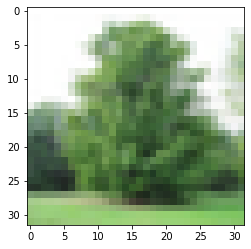

In [2]:
#test dataloader

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

import matplotlib.pyplot as plt

img_sample = samples[0]
print(img_sample.shape)
print(img_sample.shape)
plt.imshow(img_sample.permute(1, 2, 0))
plt.show()

**Training loop**

In [3]:
from mlp_mixer import *
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [4]:
def get_accuracy(predicted, true_labels):
    predicted = torch.argmax(predicted, dim=1)
    return accuracy_score(predicted, true_labels)

def save_model(model):
    import time
    filename = time.strftime("%Y%m%d-%H%M%S")
    filename = "./models/mlpmixer_"+filename+".pth"
    print(filename)
    torch.save(model.state_dict(), filename)    

In [9]:

experiment = Experiment(
    api_key="xX6qWBFbiOreu0W3IrO14b9nB",
    project_name="mlp-mixer",
    workspace="wedrid",
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_width_height = img_sample.shape[1]
patch_dims = 4
# variable_name = value #paper value
n_channels = 100 #512
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
num_layers = 8
mlp_dc_dimension = 1024 #2048 # dc è la dimensione del channel mixing (l'ultimo mlp)
mlp_ds_dimension = 128 #256 # ds è la dimensione del token mixing (il primo)

model = MLP_mixer(img_h_w=image_width_height, patch_dim=patch_dims, n_channels=n_channels, num_mixers_layers=num_layers,
    hidden_dim_mlp_token=mlp_ds_dimension, hidden_dim_mlp_channel=mlp_dc_dimension) #in this case 2 patches 16x16
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

num_epochs = 1
steps_total = len(train_loader)

hyper_params = {
    "train_size": len(train_loader),
    "validation_size": len(val_loader),
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "steps": steps_total,
    "batch_size": batch_size,
    "image_width_and_height": image_width_height,
    "patch_width_and_height": patch_dims,
    "hidden_dim_size (n_channels)": n_channels,
    "number_of_layers": num_layers,
    "mlp_dc_dimension": mlp_dc_dimension,
    "mlp_ds_dimension": mlp_ds_dimension
}

experiment.log_parameters(hyper_params)

# training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_accuracy = 0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # [100, 3, 36, 36] is what is returned by iterator
        images = images.to(device)
        true_labels = labels.to(device)
        
        # forward pass
        predicted = model(images)
        loss = loss_func(predicted, true_labels)
        train_accuracy += get_accuracy(predicted, true_labels)

        # backwards pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if False and (i+1) % 100:
            print(f'epoch: {epoch+1} of {num_epochs}, step {i+1} of {steps_total}, loss = {loss.item():.4f}')
    print(f"Loss of epoch {epoch+1}: {loss.item():.4f}")
    train_accuracy /= len(train_loader)
    experiment.log_metric("train epoch loss", loss.item(), step=epoch)
    experiment.log_metric("mean train epoch accuracy", train_accuracy, step=epoch)
    # validation
    with torch.no_grad():
        model.eval()
        val_accuracy = 0
        for i, (images, labels) in enumerate(tqdm(val_loader)):
            # [100, 3, 36, 36] is what is returned by iterator
            images = images.to(device)
            true_labels = labels.to(device)
            
            # forward pass
            predicted = model(images)
            loss = loss_func(predicted, true_labels)
            val_accuracy += get_accuracy(predicted, true_labels)
        val_accuracy /= len(val_loader)
        experiment.log_metric("val epoch loss", loss.item(), step=epoch)
        experiment.log_metric("mean val epoch accuracy", val_accuracy, step=epoch)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wedrid/mlp-mixer/92521f82e0ec4f02b3fbc755e17f9f91
COMET INFO:   Parameters:
COMET INFO:     batch_size                   : 250
COMET INFO:     epochs                       : 1
COMET INFO:     hidden_dim_size (n_channels) : 100
COMET INFO:     image_width_and_height       : 32
COMET INFO:     learning_rate                : 0.001
COMET INFO:     mlp_dc_dimension             : 1024
COMET INFO:     mlp_ds_dimension             : 128
COMET INFO:     number_of_layers             : 8
COMET INFO:     patch_width_and_height       : 8
COMET INFO:     steps                        : 140
COMET INFO:     train_size                   : 140
COMET INFO:     validation_size              : 60
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 1: 3.8502


  0%|          | 0/60 [00:00<?, ?it/s]

In [10]:
save_model(model)


./models/mlpmixer_20220308-182921.pth


In [7]:
examples = iter(train_loader)
images, labels = examples.next()

# metrics trial
images = images.to(device)
labels = labels.to(device)

# forward pass
outputs = model(images)
loss = loss_func(outputs, labels)

#da mettere nel ciclo
print(outputs.shape)

#####
predicted = torch.argmax(outputs, dim=1)
accuracy = accuracy_score(predicted, labels)
print(f'Accuracy {accuracy}')
#####
print(predicted.shape)
print(predicted)


torch.Size([250, 100])
Accuracy 0.116
torch.Size([250])
tensor([49, 53, 95, 86,  0, 73, 36,  0, 27, 36, 66, 36, 95, 20, 24, 36,  0, 69,
        68,  7, 73, 47,  5, 36, 18, 34, 73, 34,  0, 54, 36, 41, 17, 34, 17, 42,
        53, 60, 36,  0, 36, 78,  0, 36, 52, 57, 17,  0, 51, 73,  5, 47,  0, 53,
        52, 78, 53, 36, 21, 78,  7, 36, 86, 60, 27, 53, 64, 36, 52, 52, 69, 27,
        37, 69, 69, 69,  0, 36, 36, 42, 43,  5, 69, 41, 37, 89, 53, 37, 36, 69,
        42, 47, 60, 22, 24, 52, 57, 94, 53, 34, 95, 34, 34, 16, 24,  3,  3, 95,
        78, 77, 42, 18, 61, 17, 34, 69, 73, 33, 86, 36, 54, 34, 36, 34, 36, 21,
         5, 69, 60, 53, 60, 42, 60, 17, 31, 53, 36, 41, 53, 69, 68, 36, 94, 31,
         3,  7, 62, 68, 52, 36, 41, 47, 34, 34, 95, 82, 60,  3, 54, 53, 17, 36,
        92, 37,  5, 73, 60, 41, 89, 92, 36, 18, 21, 36, 86, 43, 49, 42, 62, 73,
        18, 97, 95,  0, 43,  0, 56, 97, 24, 69, 43, 54, 18, 83, 36, 48, 43, 60,
        37, 17, 54, 52, 34, 54, 82,  3, 27, 34, 34, 43, 24,  3, 